# Sentiment Analysis based on Reading Attention Span
This notebook extracts semantic segments from HTML files of all webpages, and calculate correponding weights based on human reading attentioen span and dacay.

### Semantic Segments Extraction

In [19]:
# install nltk if haven't: 
#   pip install nltk
# download the necessary NLTK data if haven't: 
#   nltk.download('punkt')
#   nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer, PorterStemmer 
from nltk.tokenize import word_tokenize
import nltk
from bs4 import BeautifulSoup
import os
import pandas as pd
import re
from collections import defaultdict
import json

In [14]:
# Please note that the dataset is gitignored due to its size, therefore please download it from the following link:
# https://snap.stanford.edu/data/wikispeedia/wikispeedia_articles_html.tar.gz
# https://snap.stanford.edu/data/wikispeedia/wikispeedia_paths-and-graph.tar.gz
# and then put it into the dataset folder under emotion folder as following:
# ADA-2024-PROJECT-TADA2024
# ├── emotion
# │   ├── dataset
# │   │   ├── wpcd
# │   │   ├── wikispeedia_paths-and-graph

html_dir = 'dataset/wpcd/wp' 
paths_dir = 'dataset/wikispeedia_paths-and-graph/paths_finished.tsv' 

### HTML Content Preprocessing and Extraction with Hyperlink Preservation

We considered the action of \
•	Lemmatization: Reduces words to their base form (e.g., “running” to “run”). \
•	Stemming: Trims words to their root (e.g., “jumps” to “jump”).

Benefits of Lemmatization and Stemming in Sentiment Analysis

1.	Both lemmatization and stemming reduce words to a common form, which can help models by reducing vocabulary size and focusing on the base meaning of words. For instance, “amazing” and “amazingly” become “amaz,” which may help a simpler model recognize these as similar in sentiment.
2.	Reducing Noise: Variations in verb tenses or plural forms don’t usually impact sentiment. By simplifying “running,” “ran,” and “runs” to “run,” the model can better focus on the emotional content of the words rather than linguistic variations.

Drawbacks of Lemmatization and Stemming

1.	Loss of Nuance: Stemming, in particular, can lead to words losing critical distinctions. For example, “happy” and “happiness” might both be stemmed to “happi,” which removes any slight difference in meaning or intensity that could be relevant to sentiment.
2.	Complicated Sentiment Contexts: Certain suffixes can carry sentiment information. For instance, “help” (neutral) versus “helpful” (positive). Stemming might remove these subtle distinctions, potentially reducing accuracy.

However, for transformer models (e.g., BERT, RoBERTa) or when working with models trained on large datasets, as these models already account for nuanced variations. Modern models handle token variations well, and stemming can reduce performance by discarding subtle context. Therefore, lemmatization alone might be a safer choice than stemming. It preserves word meaning more accurately, while still standardizing some forms. Stemming might only be beneficial for smaller, less nuanced datasets where word reduction is crucial.

Hence, we only perform lemmatization here.


Extracts readable text from HTML content while preserving hyperlinks. The anchor tags in the HTML content will be converted to a format that includes the anchor text and URL in the form `[anchor_text](URL)`. The function splits the text into sentences to make it more aligned with natural reading behavior.

In [31]:
# Initialize lemmatizer and stemmer
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    """
    Tokenizes and lemmatizes each word in the text.
    """
    words = word_tokenize(text)
    lemmatized = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized)

def extract_text_from_html(html_content):
    """
    Extracts readable text from HTML content, preserves hyperlinks with anchor text,
    performs lemmatization and stemming, and splits it into sentences.
    """
    soup = BeautifulSoup(html_content, 'html.parser')
    
    # Process anchor tags to preserve hyperlink text and URL
    for a in soup.find_all('a', href=True):
        # Replace each anchor tag with '[anchor_text](url)' format
        a.replace_with(f"[{a.get_text()}](URL)")
    
    # Get the full text with preserved hyperlinks
    text = ' '.join(soup.stripped_strings)
    
    # Split text into sentences based on punctuation
    sentences = re.split(r'(?<=[.!?]) +', text)
    
    # Apply preprocessing (lemmatization and stemming) to each sentence
    processed_sentences = [preprocess_text(sentence) for sentence in sentences]
    
    return processed_sentences

### Processing Each HTML File and extract sentences as semantic segments
This block will go through each file in the directory and organize the extracted sentences into a DataFrame. Each row in the dataframe is the sentence corpus for each webpage, and each column is a sentence after preprocessing (after lemmatisation and tag removal except the link tag).

In [32]:
df = pd.DataFrame()
extraction_path = html_dir

## Filtering Non-HTML Files
# ery file in the folder is an HTML file, so this code filters out non-HTML files 
# Only files with `.html` or `.htm` extensions are read and processed.

# Calculate total number of files for progress tracking
total_files = sum(
    len([name for name in os.listdir(os.path.join(extraction_path, folder)) if name.endswith(('.html', '.htm'))])
    for folder in os.listdir(extraction_path)
    if os.path.isdir(os.path.join(extraction_path, folder))
)

# Initialize a counter for processed files
processed_files = 0

# Process each HTML file in the folder
print("preprocessing starts")
for folder_name in os.listdir(extraction_path):
    folder_path = os.path.join(extraction_path, folder_name)
    if os.path.isdir(folder_path):
        for file_name in os.listdir(folder_path):
            # Check if the file has an HTML extension
            if file_name.endswith(('.html', '.htm')):
                file_path = os.path.join(folder_path, file_name)
                
                # tries utf-8 encoding first and, if it fails, 
                # switches to latin-1, which can handle a wider range of byte sequences.
                try:
                    with open(file_path, 'r', encoding='utf-8') as file:
                        html_content = file.read()
                except UnicodeDecodeError:
                    with open(file_path, 'r', encoding='latin-1') as file:
                        html_content = file.read()
                
                # Process the HTML content
                sentences = extract_text_from_html(html_content)
                
                # Create a temporary DataFrame for this file
                temp_df = pd.DataFrame([sentences], index=[file_name])
                
                # Concatenate to main DataFrame
                df = pd.concat([df, temp_df])
                
                # Update and display progress
                processed_files += 1
                if processed_files % 500 == 0:
                    print(f"Processed {processed_files}/{total_files} files")

# df.head()
df.to_csv('dataset/extracted_sentences.csv', index=True)
print('preprocessing finished and sentence corpus with link tag for each webpage is save as .csv')


preprocessing starts
Processed 500/5462 files
Processed 1000/5462 files
Processed 1500/5462 files
Processed 2000/5462 files
Processed 2500/5462 files
Processed 3000/5462 files
Processed 3500/5462 files
Processed 4000/5462 files
Processed 4500/5462 files
Processed 5000/5462 files
preprocessing finished and sentence corpus with link tag for each webpage is save as .csv


In [30]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,721,722,723,724,725,726,727,728,729,730
Royal_Marines.htm,Royal Marines Royal Marines [ 2007 Schools Wik...,Related subject : [ Military History and War ]...,A core component of the country 's Rapid Deplo...,"The high level of training and competence , co...",The Royal Marines are a component part of the ...,Role Corps of Royal Marines Cap Badge of the R...,As the United Kingdom Armed Forces ' specialis...,In common with the other armed force the Royal...,"Command , Control and Organisation Command of ...",The operational capability of the Corps compri...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Recycling.htm,Recycling Recycling [ 2007 Schools Wikipedia S...,Related subject : [ Environment ] ( .. /index/...,[ Environmental science ] ( .. / .. /wp/e/Envi...,Recycling prevents useful material resource be...,Recycling is a key concept of modern [ waste m...,"Recyclable material , also called `` recyclabl...",They include [ glass ] ( .. / .. /wp/g/Glass.h...,"Biodegradable waste , such a food waste or gar...",Recyclates need to be sorted and separated int...,Contamination of the recylates with other mate...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Retreat_of_glaciers_since_1850.htm,Retreat of glacier since 1850 Retreat of glaci...,Related subject : [ Climate and the Weather ] ...,"Studied by glaciologists , the temporal coinci...",Mid-latitude mountain range such a the [ Himal...,The Little Ice Age wa a period from about 1550...,"Subsequently , until about 1940 glacier around...","Glacial retreat slowed and even reversed , in ...","However , since 1980 a significant global warm...",In location such a the Andes of [ South Americ...,"The retreat of mountain glacier , notably in w...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Remember_Girls_Like_Rajpura.htm,How Remembering a Charity help [ SOS Chidren '...,She share with u her success story .,My Success Story I came to SOS Children 's Vil...,At that point I could have never thought that ...,My SOS mother wa very supportive and always en...,"After getting grade ' A ' in class eight , my ...",At school I played badminton and also particip...,"Looking at my performance in badminton , my sp...","After class twelve , I joined Guru Nanak Khals...",Hostel life wa a different experience all toge...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rutherfordium.htm,Rutherfordium Rutherfordium [ 2007 Schools Wik...,Related subject : [ Chemical element ] ( .. /i...,This is a highly radioactive synthetic element...,This element therefore ha no application and l...,Rutherfordium is the first transactinide eleme...,History Rutherfordium ( named in honour of not...,Researchers there bombarded 242 [ Pu ] ( .. / ...,In 1969 researcher at the University of Califo...,The UC group also stated that they could not r...,This resulted in an element naming controversy...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Attention Span Weight Calculation

### Link Attention Modelling

First we will generate a dictionary the contains the count of each linked link corresponding with each target.

Reasoning:
> To model human attention in navigation, we hypothesize that a human navigator is likely to focus more on links or titles that are relevant to their end goal, or target article. By examining real human behavioral data, we can derive a dictionary that quantifies the frequency of articles encountered on the way to each target article. This dictionary serves as an indicator of the correlation between each intermediate link/title and the target article.

> This correlation relationship gives insight into a human's inclination to choose specific links or titles based on their relevance to the target. In other words, the more frequently an article appears in paths leading to a particular target, the more likely it reflects a natural inclination or preference in human navigation behavior. The unclicked links will share the same ambigutious / preassumed inclination.

In [20]:
file_path = 'dataset/wikispeedia_paths-and-graph/paths_finished.tsv' # we only consider the finished paths
# Load the TSV file, skipping initial non-data rows and specifying column names
data = pd.read_csv(file_path, sep='\t', comment='#', header=0, names=["hashedIpAddress", "timestamp", "durationInSec", "path", "rating"])

# Initialize a dictionary to store counts for each target article
target_count_dict = defaultdict(lambda: defaultdict(int))

# Process each path to count frequencies
for path in data['path']:
    articles = path.split(';')  # Split articles in the path by ";"
    if articles:
        target_article = articles[-1]  # Last article is the target
        for article in articles[:-1]:  # Count articles leading up to the target
            target_count_dict[target_article][article] += 1

# Convert nested dictionary to a regular dictionary for display or further processing
target_count_dict = {target: dict(counts) for target, counts in target_count_dict.items()}

# Display result
print("Sample output for target articles and counts leading to each:")
for target, counts in list(target_count_dict.items())[:5]:  # Display sample for brevity
    print(f"Target Article: {target}")
    print("Counts:", counts)
    print()

output_path = 'dataset/link_freq_dict.json' # title click frequency for each target
with open(output_path, 'w') as f:
    json.dump(target_count_dict, f)

print("Dictionary saved as link_freq_dict.json")

Sample output for target articles and counts leading to each:
Target Article: African_slave_trade
Counts: {'14th_century': 2, 'Europe': 3, 'Africa': 16, 'Atlantic_slave_trade': 18, 'Niger': 1, 'Nigeria': 1, 'British_Empire': 1, 'Slavery': 8, 'Police_state': 4, 'Police': 1, 'United_States': 12, 'Washington%2C_D.C.': 2, '<': 2, 'George_Washington': 1, 'President_of_the_United_States': 2, 'United_States_Constitution': 1, 'Government': 1, 'George_W._Bush': 2, 'September_11%2C_2001_attacks': 1, 'New_York_City': 1, 'Business': 1, 'Economics': 1, 'War': 1, 'Game_theory': 1, 'Television': 1, 'Film': 1, 'Animation': 1, 'The_Lion_King': 1, 'Lion': 1, 'Mammal': 1, 'Scientific_classification': 1, 'Organism': 1, 'Life': 1, 'Energy': 1, 'Aristotle': 1, 'Ancient_Greece': 1, 'Christianity': 1, '16th_century': 1, 'Leonardo_da_Vinci': 1, 'Mona_Lisa': 1, 'Paris': 1, 'France': 1, 'Germany': 1, 'Austria': 1, 'German_language': 1, 'Liechtenstein': 1, 'Monaco': 1, 'Constitutional_monarchy': 1, 'Japan': 1, 'J

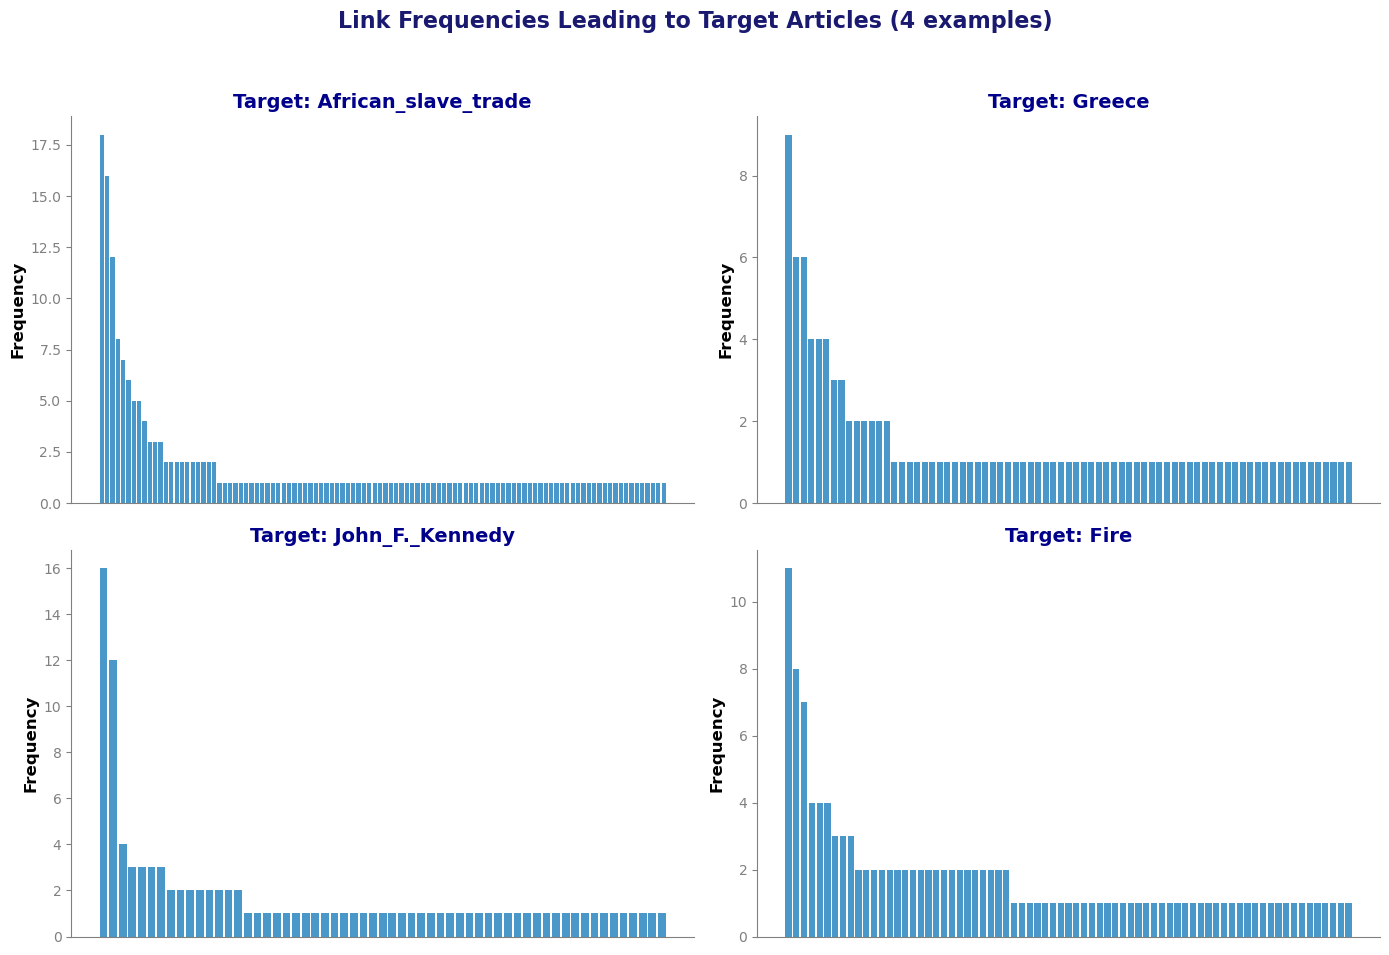

In [28]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Load the dictionary from the JSON file
json_file_path = 'dataset/link_freq_dict.json'
with open(json_file_path, 'r') as f:
    target_count_dict = json.load(f)

# Select a few target articles to visualize
sample_targets = list(target_count_dict.keys())[:4]  # Visualize the first 5 target articles for brevity

# Set up the figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Link Frequencies Leading to Target Articles (4 examples)", fontsize=16, fontweight='bold', color='midnightblue')

# Color map for bar colors
colors = cm.Blues(0.6)

# Plot each target in a subplot
for i, target in enumerate(sample_targets):
    # Get articles and frequencies, sorted by frequency
    articles = list(target_count_dict[target].keys())
    frequencies = list(target_count_dict[target].values())
    sorted_data = sorted(zip(frequencies, articles), reverse=True)
    sorted_frequencies, sorted_articles = zip(*sorted_data)
    
    # Choose the subplot
    ax = axs[i // 2, i % 2]
    bars = ax.bar(sorted_articles, sorted_frequencies, color=colors)
    
    # Styling
    ax.set_title(f"Target: {target}", fontsize=14, fontweight='semibold', color='darkblue')
    ax.set_ylabel("Frequency", fontsize=12, fontweight='semibold')
    ax.set_xticks([])  # Hide x-axis labels for clarity
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('grey')
    ax.spines['bottom'].set_color('grey')
    ax.tick_params(axis='y', colors='grey')

# Adjust layout for a clean look
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave space for the main title
plt.show()

Exponential Distribution of Frequencies: 
 
In each target’s subplot, the frequencies of articles leading to the target display an exponential-like property: a small number of articles have high frequencies, while most other articles appear less frequently. This indicates that users tend to follow a few common paths when navigating to a target, suggesting a strong preference for specific links that are likely perceived as highly relevant to the end goal.

### Sentence Weight Assignment

To model user attention, we assume that users are more likely to focus on links within sentences, as these links serve as potential pathways to reach their target. Therefore, sentences containing links (`[ anchor_text ] ( URL )`) are assigned relatively higher weights than those without links, which share a baseline weight.

In addition, we use link click frequency as an indicator of the attention drawn by each link. Links that have been clicked more frequently are likely to be perceived as more relevant or interesting, indicating a higher level of attention from users. Consequently, the weight for each link is proportional to its click frequency, and links with higher click frequencies are assigned greater weights than those with no recorded clicks.

The weight assignment method is formalised as following:

> Mathematical Expression for Sentence Weight Assignment

To model sentence weight based on link presence and click frequency, we define the following:

1. Let $S$ be a sentence.
2. Let $L_i$ represent each link in sentence $S$, where $i = 1, 2, \ldots, n$ (if there are $n$ links in the sentence).
3. Let $f(L_i)$ denote the click frequency of link $L_i$.
4. Let $W_{baseline}$ represent the baseline weight assigned to sentences with no links.

> Weight Assignment Formula

The weight $W(S)$ for sentence $S$ is assigned as follows:

1. **If $S$ contains no links**, assign a baseline weight:
   $$
   W(S) = W_{\text{baseline}}
   $$

2. **If $S$ contains links**, the weight of $S$ is calculated based on a normalized sum of the click frequencies for the links in $S$:
   $$
   W(S) = W_{\text{baseline}} + k \cdot \sum_{i=1}^n \frac{f(L_i)}{\text{\#links for target}}
   $$
   where:
   - $W_{\text{baseline}}$ is the baseline weight for sentences without links.
   - $k$ is a proportionality constant that scales the contribution of click frequency to the overall sentence weight.
   - $f(L_i)$ represents the click frequency of link $L_i$.
   - $\text{\#links for target}$ is the total sum of click frequencies for all links leading to the specified target.


> Explanation of the Formula

- **Baseline Weight $W_{\text{baseline}}$**: Ensures that every sentence has a minimum weight, even if it contains no links.
- **Click Frequency Contribution**: The term $\sum_{i=1}^n k \cdot f(L_i)$ increases the weight for sentences containing links based on how frequently those links are clicked. The higher the frequency $f(L_i)$ for a link, the greater the weight for the sentence, reflecting increased user attention.
- **Normalization Term $\frac{f(L_i)}{\text{\#links for target}}$**: Each link’s frequency $f(L_i)$ is divided by the total click frequency for the target, ensuring that frequencies are comparable across targets with varying link counts.
- **Scaled Contribution**: The normalized click frequencies are scaled by $k$ and summed for each link in the sentence, providing an overall attention weight that reflects user focus based on link relevance and frequency.


This formula prioritizes sentences with high-frequency links, aligning with the assumption that frequently clicked links draw more user attention.

Relevant literature that justifies the choice above: 
> Kahneman, D. (1973). Attention and Effort. Prentice-Hall. This classic work emphasizes that attention is a limited resource and is selectively allocated to elements that are most informative or engaging.

Proportionality Constant ( $k$ ): This value ensures that while links with high click frequencies (popular or frequently chosen links) increase sentence weight significantly, the scaling remains moderate to reflect that human attention, even when selectively focused, tends to spread across multiple cues rather than concentrating exclusively on a single feature.

> Treisman, A. M., & Gelade, G. (1980). A feature-integration theory of attention. Cognitive Psychology, 12(1), 97-136. This study suggests that attention is directed based on feature saliency, but that it distributes across multiple features, particularly in complex tasks.

In [ ]:
sentences_df = pd.read_csv('dataset/extracted_sentences.csv')

# Load the click frequencies JSON file
with open('dataset/link_freq_dict.json', 'r') as f:
    click_frequencies = json.load(f)

# Parameters for weight calculation
W_baseline = 0.2  # Baseline weight for sentences without links
k = 0.05        # Proportionality constant for scaling click frequency contribution

# Function to calculate the weight of a sentence given a target
def calculate_sentence_weight(sentence, target, click_frequencies, W_baseline, k):
    # Find all links in the format [ anchor_text ] ( URL ) 
    links = re.findall(r'\[\s*.*?\s*\]\s*\(\s*URL\s*\)', sentence)
    
    # If no links are found, return baseline weight
    if not links:
        return W_baseline
    
    # Retrieve the click frequencies for the given target
    target_clicks = click_frequencies.get(target, {})
    
    # Calculate the total number of links for the target to normalize
    total_links_for_target = sum(target_clicks.values()) if target_clicks else 1  # Avoid division by zero
    
    # Calculate normalized weight as baseline plus scaled sum of normalized click frequencies
    link_weight_sum = sum((target_clicks.get(link, 0) / total_links_for_target) for link in links)
    weight = W_baseline + k * link_weight_sum
    return weight

In [ ]:
# Apply weight calculation to each sentence in the DataFrame
sentences_df['Weight'] = sentences_df['Sentence'].apply(
    lambda sentence: calculate_sentence_weight(sentence, click_frequencies, W_baseline, k)
)

# Save the resulting DataFrame to a new CSV file
output_path = '/mnt/data/sentence_weights.csv'
sentences_df.to_csv(output_path, index=False)

print("Sentence weights calculated and saved to sentence_weights.csv")

## Weighted Emotion Scores

Now that each sentence has an associated emotion label, we can calculate a weighted emotion score for each sentence. This score combines the previously calculated attention weight of the sentence with its emotion label, providing a more nuanced view of the emotional significance based on user attention.

Let:
- $W(S)$ be the attention weight of sentence $S$, calculated as described previously.
- $E(S)$ be the emotion label (or emotion score) associated with sentence $S$.

The weighted emotion score for each sentence $S$ is calculated as:
$$
\text{Weighted Emotion}(S) = W(S) \cdot E(S)
$$

This weighted emotion score provides a refined measure that accounts for both the emotional tone of the sentence and the likelihood that it will capture attention.

## Nested Macro Average 

To account for the nature of reading sparsity, we will calculate a **Nested Macro Average** of weighted emotion scores by progressively grouping sentences. This approach reflects the likelihood that readers pay more attention to earlier sentences and progressively less to later sections.

### Grouping Structure for Nested Macro Average

The weighted emotion scores are grouped as follows:
1. The first sentence alone: $[1]$
2. The second and third sentences together: $[2, 3]$
3. The fourth, fifth, and sixth sentences together: $[4, 5, 6]$
4. The seventh through tenth sentences together: $[7, 8, 9, 10]$
5. Continue grouping in this nested manner, with each subsequent group containing one additional sentence.

### Steps for Calculating the Nested Macro Average

1. **Calculate the Weighted Emotion for Each Group**: For each group, calculate the average weighted emotion score within the group.
   
2. **Average the Grouped Scores**: After calculating the average for each group, take the average of these grouped scores to obtain the final Nested Macro Average.


Let:
- $W\_E(S_i)$ represent the weighted emotion score of sentence $S_i$.
- Groups are defined as $G_1 = [S_1]$, $G_2 = [S_2, S_3]$, $G_3 = [S_4, S_5, S_6]$, $G_4 = [S_7, S_8, S_9, S_{10}]$, and so forth, with each subsequent group expanding by one additional sentence.

The **Nested Macro Average** is calculated as:
$$
\text{Nested\_Macro\_Average} = \frac{1}{k} \sum_{j=1}^k \left( \frac{\sum_{i \in G_j} W\_E(S_i)}{|G_j|} \right)
$$
where:
- $k$ is the total number of groups,
- $G_j$ is the $j$-th group of sentences,
- $|G_j|$ is the number of sentences in group $G_j$,
- $\sum_{i \in G_j} W\_E(S_i)$ represents the sum of weighted emotions within group $G_j$.

This formula averages the weighted emotions within each group and then takes the overall average across groups. By weighting the earlier sentences more heavily, this approach provides a balanced measure that reflects both the emotional tone and the attentional distribution across the article.

Now we have the emotion annotion that consider both human attention span and reading sparsity for each article in each navigation path for each path